# Predicting Car Prices from Text Descriptions
In this notebook, we will be predicting the price of a car based on the text description of the car. You can find the competition and the dataset [here](https://www.kaggle.com/competitions/predicting-car-prices-from-text-descriptions-copy).

## 1. Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import neattext as ntx
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import joblib
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
import lightgbm as lgb
import xgboost as xgb
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

import warnings

## 2. Loading Data

In [2]:
df = pd.read_csv('train_text.csv', index_col='id')

In [3]:
df.head()

,description,price
id,,
42508,Title status: Yes. Running on Gasoline with a ...,64000
43045,Clean title: Yes. Gray exterior with Black int...,145000
34855,Available in ATLANTA: This meticulously mainta...,6995
15207,Available in Boston: This meticulously maintai...,24700
39125,Available in Detroit: This meticulously mainta...,6700


In [4]:
df.shape

(27136, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27136 entries, 42508 to 15564
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  27136 non-null  object
 1   price        27136 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 636.0+ KB


In [6]:
df.duplicated().sum()

np.int64(0)

## 3. Exploratory Data Analysis

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,27136.0,39396.979695,72688.889236,2000.0,15900.0,28000.0,45573.75,2954083.0


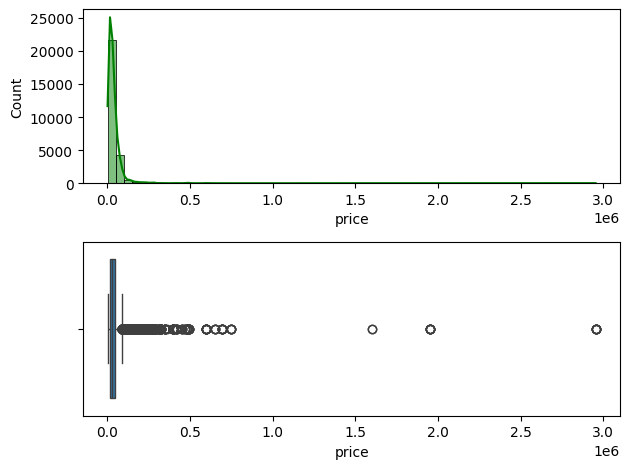

In [8]:
plt.subplot(211)
sns.histplot(x=df.price, bins=60, kde=True, color='g')

plt.subplot(212)
sns.boxplot(x=df.price)

plt.tight_layout()

In [9]:
df.price.quantile([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

0.01      3990.00
0.05      6700.00
0.10      9250.00
0.25     15900.00
0.50     28000.00
0.75     45573.75
0.90     71000.00
0.95     93999.00
0.99    229000.00
Name: price, dtype: float64

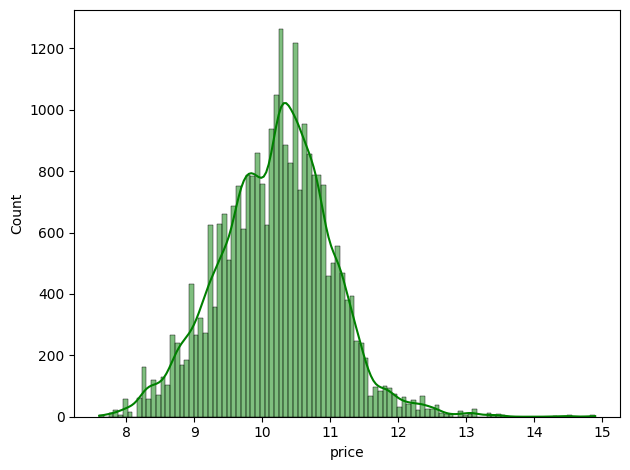

In [10]:
sns.histplot(
    x=df.price.apply(np.log1p),
    kde=True,
    color='g'
)
plt.tight_layout()

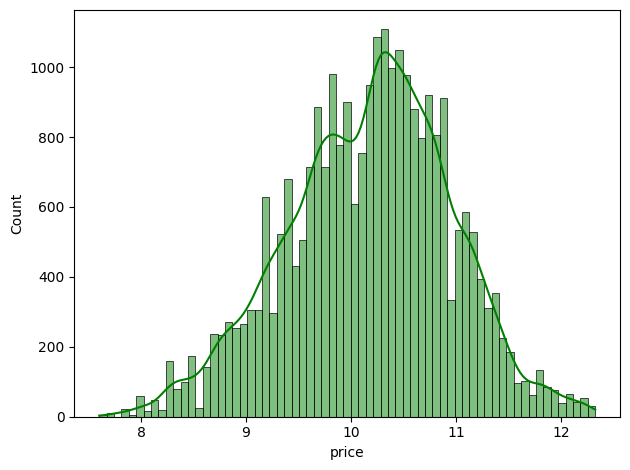

In [11]:
sns.histplot(
    x=df.price[df.price < df.price.quantile(0.99)].apply(np.log1p),
    kde=True,
    color='g'
)
plt.tight_layout()

In [12]:
df.shape

(27136, 2)

In [13]:
df[df.price < df.price.quantile(0.99)].shape

(26857, 2)

In [14]:
# Filter out extreme price outliers (top 1%) to improve model performance and reduce skewness
df = df[df.price < df.price.quantile(0.99)]

## 4. Natural Language Processing

In [15]:
def process_text(text):
    text = text.lower()
    text = ntx.remove_stopwords(text)
    text = ntx.remove_puncts(text)
    text = ntx.remove_special_characters(text)
    text = ntx.remove_multiple_spaces(text)
    return text

In [16]:
df['description_clean'] = df['description'].apply(process_text)

In [17]:
descs = ' '.join(df.description)
descs = process_text(descs)
descs[:100]

'title status yes running gasoline 5180hp electric motor electric fuel system 2022 tesla model x long'

In [18]:
def wc(text):
    wordcloud = WordCloud(
        width=800, height=400, 
        background_color='white',
    ).generate(text)
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

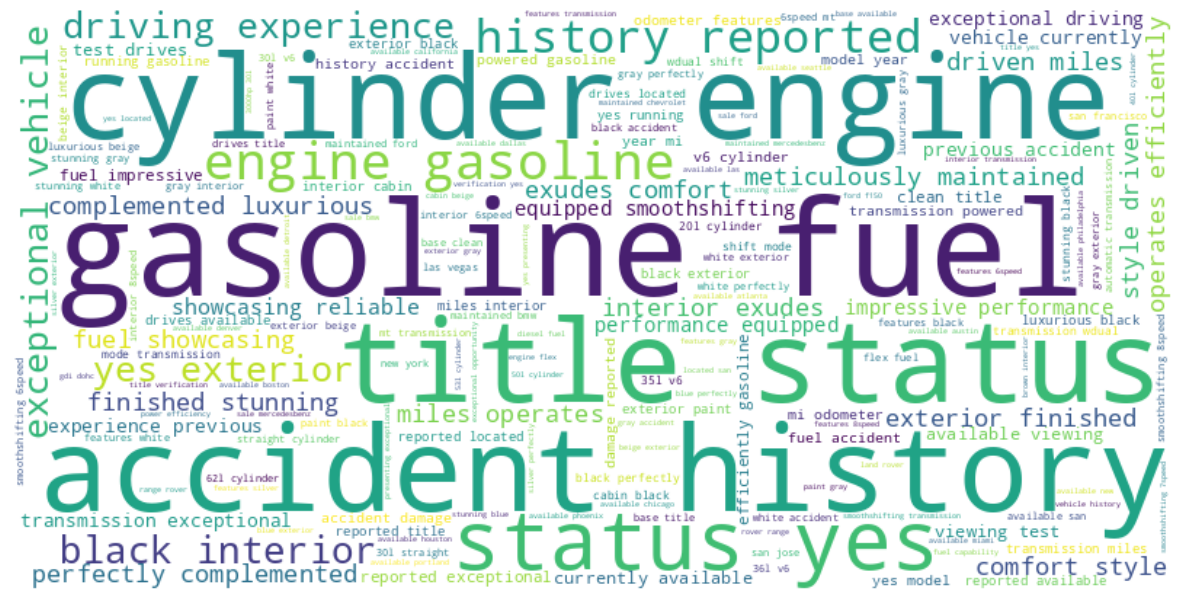

In [19]:
wc(descs)

In [20]:
expensive_cars_desc = ' '.join(df[df.price > 50000].description_clean)
cheap_cars_desc = ' '.join(df[df.price <= 50000].description_clean)

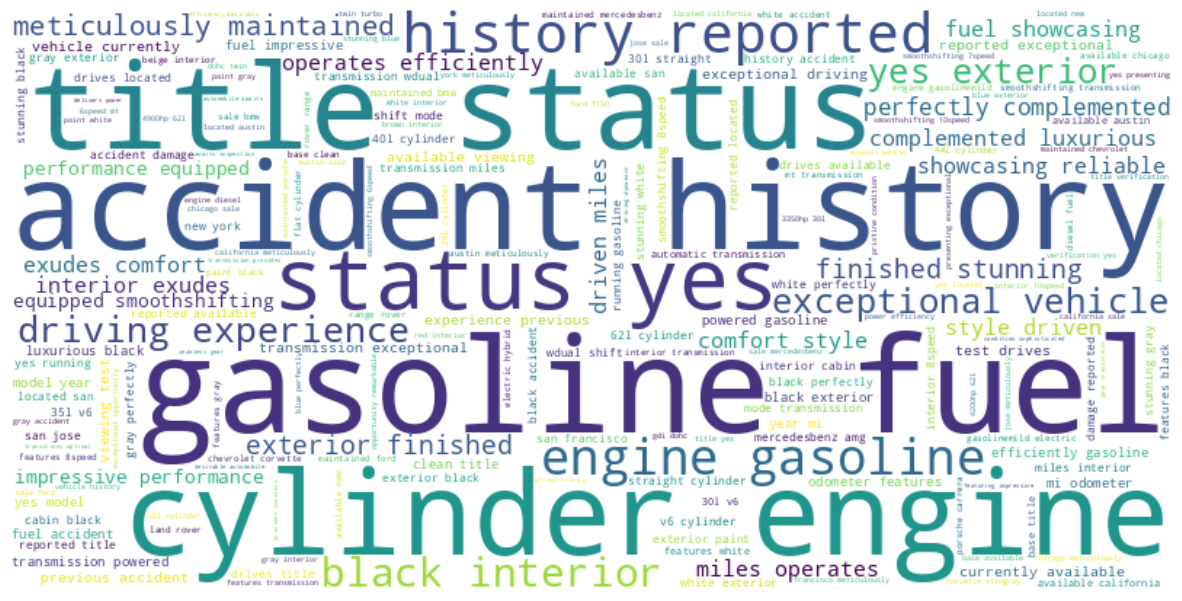

In [21]:
# Expensive cars word cloud
wc(expensive_cars_desc)

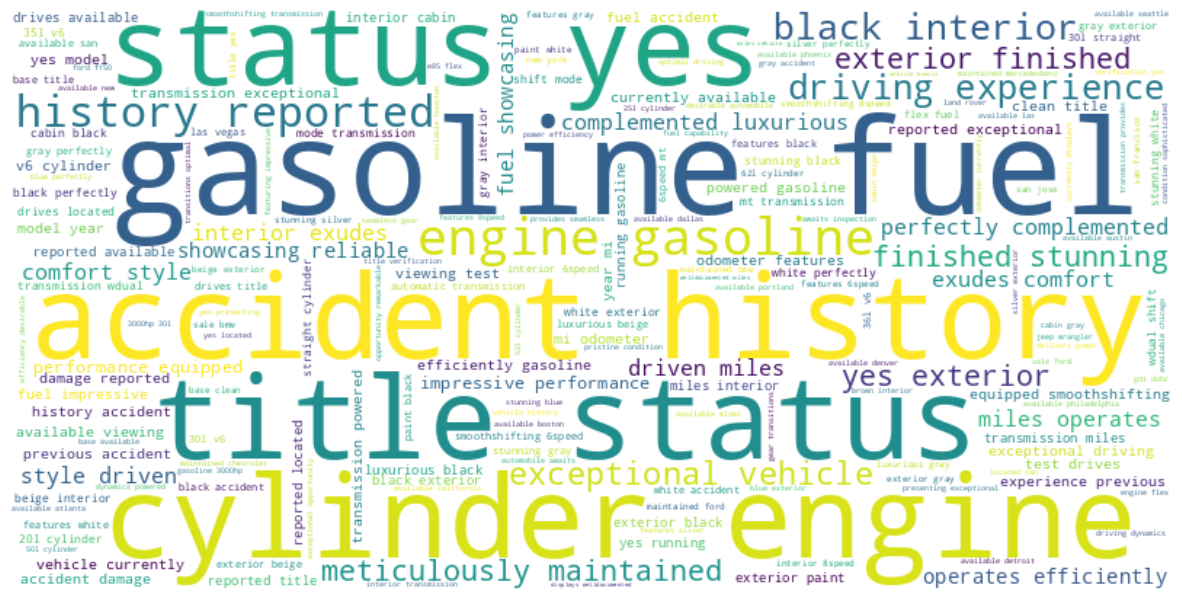

In [22]:
# Cheap cars word cloud
wc(cheap_cars_desc)

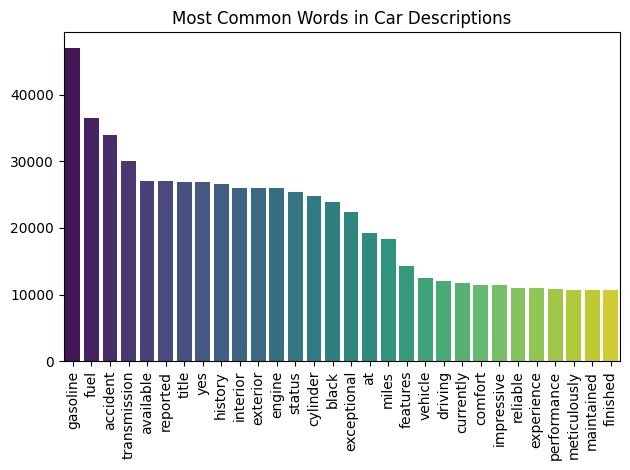

In [23]:
mcw = dict(Counter(descs.split()).most_common(30))
sns.barplot(
    x=mcw.keys(),
    y=mcw.values(),
    hue=mcw.keys(),
    palette='viridis',
)
plt.xticks(rotation=90)
plt.title('Most Common Words in Car Descriptions')
plt.tight_layout()

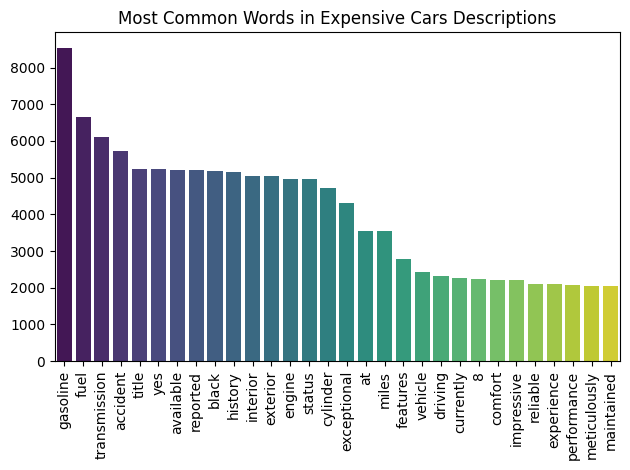

In [24]:
mcwx = dict(Counter(expensive_cars_desc.split()).most_common(30))
sns.barplot(
    x=mcwx.keys(),
    y=mcwx.values(),
    hue=mcwx.keys(),
    palette='viridis',
)
plt.xticks(rotation=90)
plt.title('Most Common Words in Expensive Cars Descriptions')
plt.tight_layout()

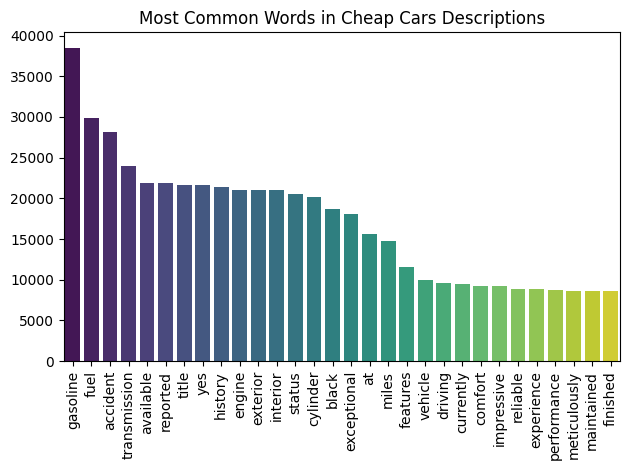

In [25]:
mcwc = dict(Counter(cheap_cars_desc.split()).most_common(30))
sns.barplot(
    x=mcwc.keys(),
    y=mcwc.values(),
    hue=mcwc.keys(),
    palette='viridis',
)
plt.xticks(rotation=90)
plt.title('Most Common Words in Cheap Cars Descriptions')
plt.tight_layout()

In [26]:
stemmer = nltk.SnowballStemmer('english')

df['description_clean'] = df.description_clean.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [27]:
df.head()

,description,price,description_clean
id,,,
42508,Title status: Yes. Running on Gasoline with a ...,64000,titl status yes run gasolin 5180hp electr moto...
43045,Clean title: Yes. Gray exterior with Black int...,145000,clean titl yes gray exterior black interior po...
34855,Available in ATLANTA: This meticulously mainta...,6995,avail atlanta meticul maintain 2006 chevrolet ...
15207,Available in Boston: This meticulously maintai...,24700,avail boston meticul maintain 2016 bmw 328 xdr...
39125,Available in Detroit: This meticulously mainta...,6700,avail detroit meticul maintain 2011 chevrolet ...


## 5. Data Preprocessing

In [28]:
x = np.array(df.description_clean)
y = np.array(df.price)

In [29]:
y_scaled = np.log1p(y)

In [30]:
# Vectorize the text data
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
x_vec = vectorizer.fit_transform(df.description_clean)

In [31]:
x_vec.shape

(26857, 34027)

In [32]:
tfidf_df = pd.DataFrame(x_vec.toarray(), columns=vectorizer.get_feature_names_out())

In [33]:
tfidf_df.head()

,065l,065l electr,10,10 cylind,100,100 mi,100 mile,1000,1000 mile,10000,...,zl1 pristin,zl1 titl,zr2,zr2 avail,zr2 clean,zr2 locat,zr2 pristin,zr2 titl,zynith,zynith perfect
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
x_train, x_test, y_train, y_test = train_test_split(x_vec, y_scaled, test_size=0.2, random_state=42)

In [35]:
x_train.shape

(21485, 34027)

## 6. Model Training

In [42]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "LightGBM": lgb.LGBMRegressor(verbose=-1),
    "XGBoost": xgb.XGBRegressor()
}

def evaluate(x_train, y_train, x_test, y_test):
    results = []
    for name, model in tqdm(models.items()):
        print(f"Training {name} model...")
        y_pred = model.fit(x_train, y_train).predict(x_test)
        
        results.append({
            "Model": name,
            "R2_Score": r2_score(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred)**0.5
        })
    report = pd.DataFrame(results).sort_values('R2_Score', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

In [43]:
evaluate(x_train, y_train, x_test, y_test)

  0%|          | 0/7 [00:00<?, ?it/s]

Training LinearRegression model...
Training Ridge model...
Training Lasso model...
Training DecisionTreeRegressor model...
Training ExtraTreeRegressor model...
Training LightGBM model...


/home/tuncer/projects/20-kaggle-competitions/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Training XGBoost model...


,Model,R2_Score,MSE,RMSE
0,Ridge,0.646391,0.226648,0.476076
1,LightGBM,0.638030,0.232007,0.481671
2,XGBoost,0.618661,0.244422,0.494390
3,ExtraTreeRegressor,0.349536,0.416919,0.645693
4,DecisionTreeRegressor,0.300587,0.448293,0.669547
5,LinearRegression,0.104790,0.573791,0.757490
6,Lasso,-0.000069,0.641001,0.800625


## 7. Build Pipeline with the best model, Save the model, Make Submission

In [51]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
    ('model', Ridge(random_state=42))
])
pipeline.fit(x, y_scaled)

,steps,"[('vectorizer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [53]:
pipeline.score(x, y_scaled)

0.7676828460199359

In [54]:
joblib.dump(pipeline, 'car_price_predictor.pkl')

['car_price_predictor.pkl']

### Submission

In [56]:
test_df = pd.read_csv('test_text.csv', index_col='id')
test_df['description_clean'] = test_df['description'].apply(process_text)
test_df['description_clean'] = test_df['description_clean'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [57]:
test_df.head()

,description,description_clean
id,,
39977,Located in Denver - For sale: Mercedes-Benz AM...,locat denver sale mercedesbenz amg g 63 base c...
47881,"Regarding vehicle history, accident status: No...",vehicl histori accid status report titl verif ...
288,Available in Dallas: This meticulously maintai...,avail dalla meticul maintain 2013 mercedesbenz...
31330,Located in San Jose - For sale: Cadillac Escal...,locat san jose sale cadillac escalad esv luxur...
31387,Title status: Yes. Running on Gasoline with a ...,titl status yes run gasolin 1810hp 16l 4 cylin...


In [61]:
predictions = pipeline.predict(test_df.description_clean)
predictions = np.expm1(predictions)
submission = pd.DataFrame({
    'id': test_df.index,
    'price': predictions
})
submission.head()

,id,price
0,39977,56158.312003
1,47881,47841.050788
2,288,22985.691426
3,31330,56714.161336
4,31387,12492.743219


In [62]:
submission.to_csv('submission.csv', index=False)

## 8. Conclusion
We built a machine learning pipeline to predict the price of a car based on the text description of the car. We used the `Ridge` model as the best model. We saved the pipeline for future use and used it to generate predictions for the test set.